# SABR Volatility Model
------------------
> **Idriss Afra**

This project aims to construct the Equity implied volatility surface under the SABR model.

## Model Description

The SABR model is a stochastic volatility model in which both the forward $F_t$ and the instantaneous volatility $\sigma_t$ are stochastic. Under the (log-normal) SABR specification, their dynamics are:

$$
\begin{align}
dF_t & = \sigma_t F_t^\beta dW_t^1\\
\frac{d\sigma_t}{\sigma_t} & = \alpha dW_t^2\\
d<W^1,W^2>_t & = \rho dt
\end{align}
$$

Where :
* $F_0$ is the forward price at $t = 0$
* $\beta$ is the CEV exponent and controls the skew curvature
* $\sigma_0$ is the initial volatility and controls the overall level of the skew
* $\alpha$ is the volatility of the volatility and controls the skew convexity
* $\rho$ is the correlation between the forward and the volatility and controls the skew asymmetry 
* $W^1$ and $W^2$ are two $\rho$-correlated standard Brownian motions

Under the SABR model, the prices of European call options are given by the Black's formula. In fact, for a current forward rate $F$, strike $K$, and implied volatility $\sigma_{SABR}(K, F, T)$, the price of an European call option with maturity T is :

$$
\begin{align}
C_{BLACK}(F_0, K, \sigma_{SABR}(K,F_0,T), T) & = e^{-rT} \left[ F_0 × N(d_1) - K × N(d_2) \right] \\
d_{1} & = \frac{ln\left(\frac{F_0}{K}\right) + \frac{1}{2} \sigma_{SABR}(K,F_0,T)^2 T}{\sigma_{SABR}(K,F_0,T) \sqrt{T}} \\
d_{2} & = d_{1} - \sigma_{SABR}(K,F_0,T) \sqrt{T}
\end{align}
$$

<br> Where $\sigma_{SABR}(K,F_0,T)$ follows the Hagan's formula (*2002 SABR Log-Normal Volatility expansion*) :

$$
\begin{align}
\sigma_{SABR}(K,F_0,T) & = \frac{\sigma_0 × \left[ 1 + \left( \frac{(1-\beta)^2}{24} × \frac{\sigma_0^2}{(F_0.K)^{1-\beta}} + \frac{1}{4} × \frac{\rho .\beta .\alpha .\sigma_0}{(F_0.K)^{(1-\beta)/2}} +\frac{\alpha^2 (2-3\rho^2)}{24} \right) × T \right]}{(F_0.K)^{(1-\beta)/2} × \left[1 + \frac{(1-\beta)^2}{24} ln^2\left(\frac{F_0}{K}\right) +  \frac{(1-\beta)^4}{1920} ln^4\left(\frac{F_0}{K}\right)\right]} × \frac{z}{\chi{(z)}} \\
z & = \frac{\alpha}{\sigma_0} × (F_0.K)^{(1-\beta)/2} × ln\left(\frac{F_0}{K}\right) \\
\chi{(z)} & = ln\left(\frac{\sqrt{1-2\rho z + z^2} + z - \rho}{1-\rho}\right)
\end{align}
$$
<br>This model is used to fit the implied volatility surface. However, it does not address potential market price arbitrages and may even introduce new arbitrages for low strikes. As a result, arbitrage correction on market prices and the application of relevant extrapolation methods for volatilities at extreme strikes are necessary.

---

## SABR Calibration Methods

To apply the SABR model, we calibrate its parameters $\beta$, $\sigma_0$, $\alpha$, and $\rho$ for each quoted expiry.

This is done by solving a global optimization problem that minimizes the squared error between SABR-implied and market-implied volatilities. For each expiry $T$, we compute :
$$
(\beta^T, \sigma_0^T, \alpha^T, \rho^T) = ArgMin_{(\beta, \sigma_0, \alpha, \rho)} \frac{1}{N_T} ∑_{K_i ∈ Market}\left(\sigma_{SABR(\beta, \sigma_0, \alpha, \rho)}(K_i,F_0,T) - \sigma_{{Market}}(K_i, T)\right)^{2}
$$

In practice, $\beta$ is often fixed manually. In this project, however, the user can either provide it as an input or treat it as an additional parameter to be calibrated within the optimization.

---

## SABR Model Implementation

In [1]:
# Required Libraries
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt
from matplotlib import cm

class SABRModel:
    """
    The SABR model class.
    """
    def __init__(self):
        """
        Init method.
        """
        self.params = {}

    def _x(self, rho, z):
        """
        The helper method x used in Hagan's 2002 SABR log-normal vol expansion.
        """
        num = (1 - 2 * rho * z + z**2)**0.5 + z - rho
        den = 1 - rho
        return  np.log (num / den)
    
    def get_sabr_vol(self, T, strike, forward, beta, sigma0, alpha, rho, eps=1e-4):
        """
        Hagan's 2002 SABR log-normal vol expansion.
        strike can be a scalar or an array.
        Returns an array of log-normal SABR vols.
        """
        # Helper parameters for the Hagan's formula
        fk_beta = (forward * strike)**(1 - beta)
        log_fk = np.log(forward / strike)
        a = ((1 - beta)**2 / 24) * (sigma0**2 / fk_beta)
        b = 0.25 * rho * beta * alpha * sigma0 / fk_beta**0.5
        c = (2 - 3 * rho**2) * alpha**2 / 24
        d = fk_beta**0.5
        e = (1 - beta)**2 * log_fk**2 / 24
        f = (1 - beta)**4 * log_fk**4 / 1920
        z = alpha * fk_beta**0.5 * log_fk / sigma0
        num = sigma0 * (1 + (a + b + c) * T)
        den = d * (1 + e + f)
        # Near ATM (K ~ F0), z -> 0 and x(z) -> 0 causing a 0/0 in z/x(z)
        # We use the limit z/x(z) -> 1 for numerical stability
        x = self._x(rho, z)
        zx = np.where(np.abs(z) < eps, 1.0, z / x)
        # SABR volatility
        return (num / den) * zx

    def params_calibration(self, expiries, forward_values, market_strikes, market_vols, beta=None, maxiter=1000, tol=1e-8):
        """
        Calibrates the SABR parameters [Beta, Sigma0, Alpha, Rho] to market data.
        """
        # Sanity checks
        if not isinstance(expiries, (list, np.ndarray)) or len(expiries) == 0:
            raise TypeError("expiries must be a non-empty list or array of expiries.")
        if np.any(np.diff(np.asarray(expiries, float)) <= 0):
            raise ValueError("Expiries must be strictly increasing.")
        if not isinstance(forward_values, dict) or not isinstance(market_strikes, dict) or not isinstance(market_vols, dict):
            raise TypeError("forward_values, market_strikes, and market_vols must be dictionaries with keys matching expiries.")
        for exp in expiries:
            if (exp not in forward_values) or (exp not in market_strikes) or (exp not in market_vols):
                raise ValueError(f"Missing data for expiry={exp}. All expiries must have corresponding entries in forward_values, market_strikes, and market_vols.")
            if len(market_strikes[exp]) != len(market_vols[exp]):
                raise ValueError(f"Length mismatch for expiry={exp}: market_strikes has length {len(market_strikes[exp])} but market_vols has length {len(market_vols[exp])}.")
        if beta is not None:
            if not isinstance(beta, (float, np.number)) or beta < 0 or beta > 1:
                raise ValueError("beta must be a number in the range [0, 1].")
        if not isinstance(maxiter, int) or maxiter <= 0:
            raise ValueError("maxiter must be a positive integer.")
        if not isinstance(tol, (float, np.number)) or tol <= 0:
            raise ValueError("tol must be a positive number.")
        # Store attributes
        self.expiries = expiries
        self.forward_values = forward_values
        self.market_strikes = market_strikes
        self.market_vols = market_vols
        # SABR calibration process
        print("Starting SABR calibration...")
        if beta is not None:
            print(f"Calibrating SABR parameters with fixed Beta={beta:.4f}...")
        else:
            print("Calibrating SABR parameters with free Beta...")
        results = {}
        for i in range(len(expiries)):
            params = self._fit_slice(expiries[i], forward_values[expiries[i]], np.array(market_strikes[expiries[i]]), np.array(market_vols[expiries[i]]), beta, maxiter, tol)
            # Store the calibrated parameters for the current expiry if the solver succeeded, otherwise ignore this expiry
            if params is None: continue
            results[round(expiries[i], 12)] = params
        self.params = results

    def _obj_func(self, params, T, forward, market_strikes, market_vols, beta=None):
        """
        The objective method of the SABR calibration.
        => SSE of the implied volatilities.
        params = [Sigma0, Alpha, Rho] if beta is fixed and params = [Beta, Sigma0, Alpha, Rho] if beta is free.
        """
        if beta is None:
            beta_, sigma0, alpha, rho = params
        else:
            sigma0, alpha, rho = params
            beta_ = beta
        sabr_vols = self.get_sabr_vol(T, market_strikes, forward, beta_, sigma0, alpha, rho)
        sse = np.mean((sabr_vols - market_vols)**2)
        return 10000 * sse
    
    def _fit_slice(self, T, forward, market_strikes, market_vols, beta=None, maxiter=1000, tol=1e-8):
        """
        Fits a single slice of the SABR surface for a given expiry T.
        Returns the calibrated SABR parameters: [Beta, Sigma0, Alpha, Rho].
        """
        moneyness = market_strikes / forward - 1
        closest_atm_index = np.argmin(np.abs(moneyness))
        closest_atm_vol = market_vols[closest_atm_index]
        if beta is not None:
            # Initial guess and bounds for the SABR parameters : Sigma0, Alpha, and Rho
            init_params = np.array([closest_atm_vol * forward**(1 - beta), 0.5, -0.3])
            bounds_params = ((1e-4, 3.), (1e-4, 5.), (-0.99, 0.99))
            # Solver
            res = minimize(self._obj_func, x0=init_params, args=(T, forward, market_strikes, market_vols, beta), 
                            method="L-BFGS-B", bounds=bounds_params, options={"maxiter" : maxiter}, tol=tol)
            # Check the solver result and return the calibrated parameters
            if res.success:
                sigma0, alpha, rho = res.x.astype(float).tolist()
                print(f"Solver succeeded to converge for T={T:.4f}. Calibrated parameters: Sigma0={sigma0:.4f}, Alpha={alpha:.4f}, Rho={rho:.4f}")
                return beta, sigma0, alpha, rho
            else:
                print(f"Solver failed to converge for T={T:.4f} and therefore will be ignored. Message: {res.message}")
                return None
        else:
            # Initial guess and bounds for the SABR parameters : Beta, Sigma0, Alpha, and Rho
            init_params = np.array([0.8, closest_atm_vol * forward**(1 - 0.8), 0.5, -0.3])
            bounds_params = ((1e-6, 1), (1e-4, 3.), (1e-4, 5.), (-0.99, 0.99))
            # Solver
            res = minimize(self._obj_func, x0=init_params, args=(T, forward, market_strikes, market_vols), 
                           method="L-BFGS-B", bounds=bounds_params, options={"maxiter" : maxiter}, tol=tol)
            # Check the solver result and return the calibrated parameters.
            if res.success:
                beta, sigma0, alpha, rho = res.x.astype(float).tolist()
                print(f"Solver succeeded to converge for T={T:.4f}. Calibrated parameters: Beta={beta:.4f}, Sigma0={sigma0:.4f}, Alpha={alpha:.4f}, Rho={rho:.4f}")
                return beta, sigma0, alpha, rho
            else:
                print(f"Solver failed to converge for T={T:.4f} and therefore will be ignored. Message: {res.message}")
                return None
            
    def get_vol(self, T, K, min_moneyness=0.6, max_moneyness=1.4):
        """
        SABR Volatility.
        Strike K : SABR Vol formula within [min_moneyness, max_moneyness] moneyness range and flat vol extrapolation outside.
        Expiry T : PchipInterpolator V2T interpolation & Flat Vol extrapolation.
        """
        # Sanity checks
        if not self.params : 
            raise ValueError("The SABR parameters should be calibrated first through the params_calibration method.")
        if T <= 0: raise ValueError("Expiry T must be positive.")
        if K <= 0: raise ValueError("Strikes must be positive.")
        # Vol computation
        expiries = np.array(sorted(self.params.keys()), dtype=float)
        if (T <= expiries[0]) or (T >= expiries[-1]) or np.any(np.isclose(T, expiries, atol=1e-12)):
            # Listed expiry or flat vol extrapolation
            T_clamped = min(expiries[-1], max(expiries[0], T))
            key = round(T_clamped, 12)
            min_vol_strike = self.forward_values[key] * min_moneyness
            max_vol_strike = self.forward_values[key] * max_moneyness
            vol_strike = min(max_vol_strike, max(min_vol_strike, K))
            return self.get_sabr_vol(T_clamped, vol_strike, self.forward_values[key], self.params[key][0], self.params[key][1], self.params[key][2], self.params[key][3])
        else:
            # Use the SABR formula to compute the volatilities at the listed expiries for the given strike K
            vols_K = np.array([])
            for exp in expiries:
                min_vol_strike = self.forward_values[exp] * min_moneyness
                max_vol_strike = self.forward_values[exp] * max_moneyness
                vol_strike = min(max_vol_strike, max(min_vol_strike, K))
                vol = self.get_sabr_vol(exp, vol_strike, self.forward_values[exp], self.params[exp][0], self.params[exp][1], self.params[exp][2], self.params[exp][3])
                vols_K = np.append(vols_K, vol)
            # Create a PCHIP interpolator for the SABR V2T across expiries
            v2T_interp = PchipInterpolator(expiries, vols_K**2 * expiries)
            return np.sqrt(v2T_interp(T) / T)
        
    def plot_sabr_surface(self, min_moneyness=0.6, max_moneyness=1.4, min_T=0.5, n_interv=81):
        """
        SABR 3D surface plotter : Implied volatility surface.
            * 81x81 grid by default.
            * 60% - 140% moneyness range by default.
            * From min_T to the maximum calibrated expiry range by default.
        """
        # Sanity checks
        if not self.params : raise ValueError("The SABR parameters should be calibrated first through the params_calibration method.")
        if not isinstance(n_interv, int) or n_interv < 10:
            raise ValueError("n_interv must be an integer >= 10.")
        if min_T <= 0 or min_T >= list(self.params.keys())[-1]:
            raise ValueError("min_T must be positive falling before the maximum expiry.")
        # min/max forwards
        min_fwd = min(self.forward_values.values())
        max_fwd = max(self.forward_values.values())
        # Surface data computation
        min_K = min_fwd * min_moneyness
        max_K = max_fwd * max_moneyness
        K = np.linspace(min_K, max_K, n_interv, endpoint=True)
        T = np.linspace(min_T, list(self.params.keys())[-1], n_interv, endpoint=True)
        K, T = np.meshgrid(K, T)
        vols = np.zeros(shape=K.shape)
        for t in range(vols.shape[0]):
            for k in range(vols.shape[1]):
                vols[t, k] = self.get_vol(T[t][k], K[t][k])
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(projection='3d')
        surf = ax.plot_surface(K, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        ax.set_xlabel("Strike (K)", labelpad=10)
        ax.set_ylabel("Time to expiry (T)", labelpad=10)
        # Workaround to ensure the display of the zlabel 
        ax.set_zlabel("")
        ax.text2D(
            1.05, 0.52, "Implied volatility (σ)",
            transform=ax.transAxes,
            rotation=90,
            va="center", ha="left",
            fontsize=12,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.8)
        )
        ax.set_title("Implied SABR Volatility Surface", pad=20)
        fig.subplots_adjust(left=0.02, right=0.88, bottom=0.05, top=0.92)
        # Show the plot
        plt.show()     

---
## Numerical Application : CAC40 Listed Index Options

Now, let's apply the SABR model to construct the CAC40 implied volatility surface. To achieve this, we use the CAC40 implied forwards and volatilities as of February 12, 2025, computed in the following project : [Equity Implied Forward & Volatility Surface](https://github.com/Idriss-Afra/Equity-Implied-Volatility-Surface/blob/main/Equity%20Implied%20Forward%20%26%20Volatility%20Surface.ipynb).

In [2]:
# Required Libraries
import datetime
import pandas as pd
import warnings

# Market Data Loading
as_of_date = datetime.date(2025, 2, 12)
print("Analysis Date : ", as_of_date)
print("-----------------------------------------------")
eq_underlying = "CAC40"
S0 = 8042.19
print(f"{eq_underlying} Close Price : ", S0)
print("-----------------------------------------------")
option_data = pd.read_csv(f"MarketData/{eq_underlying}_MarketData_{as_of_date.strftime('%d%m%Y')}.csv")
print(f"{eq_underlying} Option Data :")
display(option_data)
print("-----------------------------------------------")
rate_underlying = "EURIBOR6M"
print(f"{rate_underlying} Zero-Coupon Rate Curve :")
rates_data = pd.read_csv(f"MarketData/{rate_underlying}_ZCRates_{as_of_date.strftime('%d%m%Y')}.csv")
display(rates_data)

# ZC Rate Function: PCHIP Interpolation & Extrapolation
if len(rates_data) < 2:
    raise ValueError("rates_data must have at least 2 points for interpolation.")
if (rates_data['ZCRate'] < -0.1).any() or (rates_data['ZCRate'] > 0.5).any():
    warnings.warn("Some zero-coupon rates are outside typical range [-10%, 50%]. Check input data.")
if rates_data['Expiry'].is_monotonic_increasing:
    zc_rate = PchipInterpolator(rates_data['Expiry'], rates_data['ZCRate'], extrapolate=True)
else:
    raise ValueError("rates_data['Expiry'] is not monotonically increasing. Sort the data.")

Analysis Date :  2025-02-12
-----------------------------------------------
CAC40 Close Price :  8042.19
-----------------------------------------------
CAC40 Option Data :


,Expiry,Strike,Call,Put,Repo+Dividend,Forward,Volatility
0,0.024658,7925.0,151.83,27.92,-0.007504,8048.995249,0.147884
1,0.024658,7950.0,132.52,33.59,-0.007504,8048.995249,0.144937
2,0.024658,7975.0,114.13,40.18,-0.007504,8048.995249,0.141799
3,0.024658,8000.0,96.79,47.82,-0.007504,8048.995249,0.138504
4,0.024658,8025.0,81.15,57.17,-0.007504,8048.995249,0.136132
...,...,...,...,...,...,...,...
137,4.857534,8000.0,977.10,1115.35,0.026932,7847.326546,0.168501
138,4.857534,8400.0,808.07,1308.91,0.026932,7847.326546,0.163183
139,4.857534,8800.0,665.26,1528.71,0.026932,7847.326546,0.159257
140,4.857534,9600.0,450.36,2039.01,0.026932,7847.326546,0.154882


-----------------------------------------------
EURIBOR6M Zero-Coupon Rate Curve :


,Expiry,ZCRate
0,0.02,0.0268
1,0.25,0.0264
2,0.50,0.0251
3,0.75,0.0239
4,1.00,0.0233
5,1.25,0.0228
6,1.50,0.0226
7,1.75,0.0225
8,2.00,0.0224
9,2.50,0.0225


First, let's collect the market data and calibrate the SABR on each listed expiry. We assume a fixed $\beta$ input at 0.8.

Starting SABR calibration...
Calibrating SABR parameters with fixed Beta=0.8000...
Solver succeeded to converge for T=0.0247. Calibrated parameters: Sigma0=0.7936, Alpha=3.6331, Rho=-0.3855
Solver succeeded to converge for T=0.1014. Calibrated parameters: Sigma0=0.8168, Alpha=2.1378, Rho=-0.4270
Solver succeeded to converge for T=0.1781. Calibrated parameters: Sigma0=0.8268, Alpha=1.6361, Rho=-0.4894
Solver succeeded to converge for T=0.3507. Calibrated parameters: Sigma0=0.8470, Alpha=1.2387, Rho=-0.5324
Solver succeeded to converge for T=0.6000. Calibrated parameters: Sigma0=0.8778, Alpha=1.0257, Rho=-0.5341
Solver succeeded to converge for T=0.8493. Calibrated parameters: Sigma0=0.9085, Alpha=0.8635, Rho=-0.5432
Solver succeeded to converge for T=1.0986. Calibrated parameters: Sigma0=0.9187, Alpha=0.7329, Rho=-0.5802
Solver succeeded to converge for T=1.3479. Calibrated parameters: Sigma0=0.9347, Alpha=0.6494, Rho=-0.5934
Solver succeeded to converge for T=1.5973. Calibrated paramet

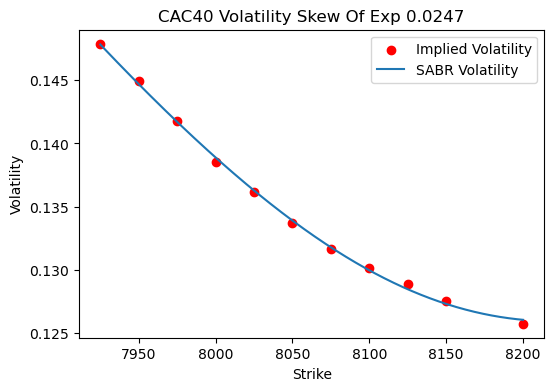

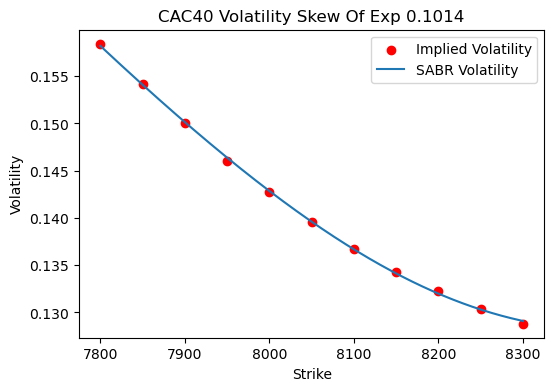

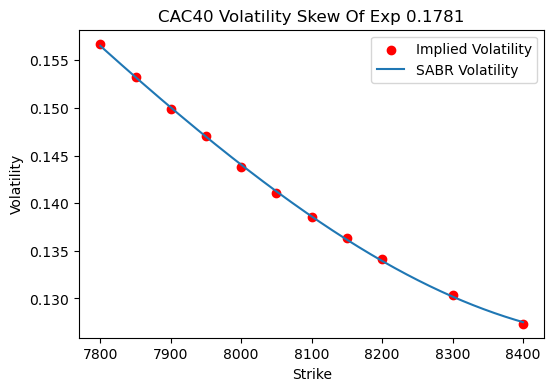

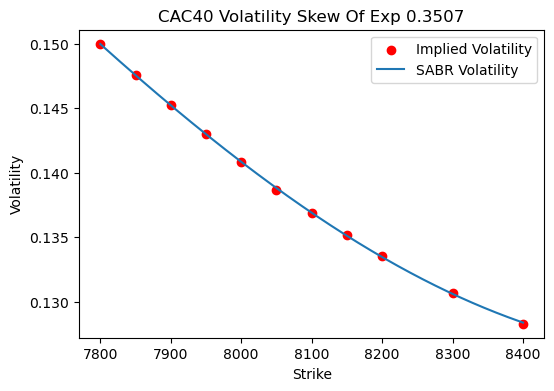

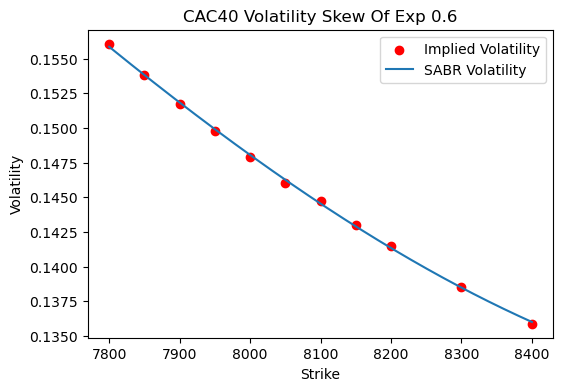

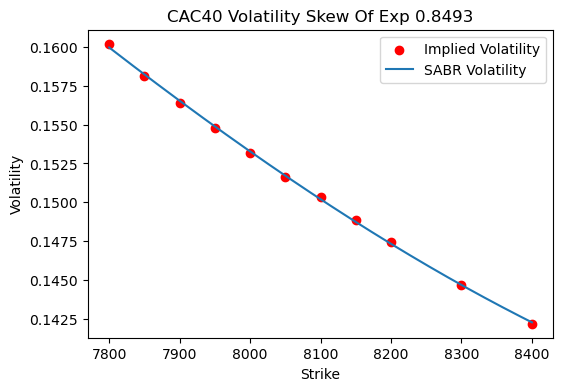

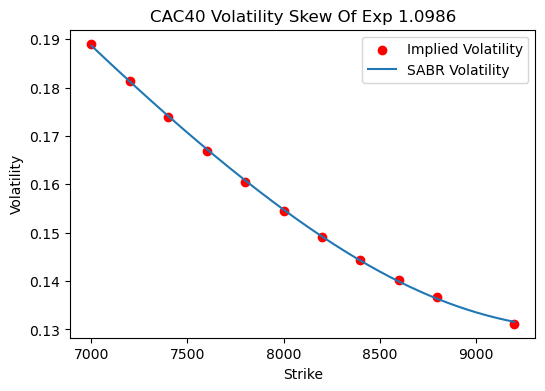

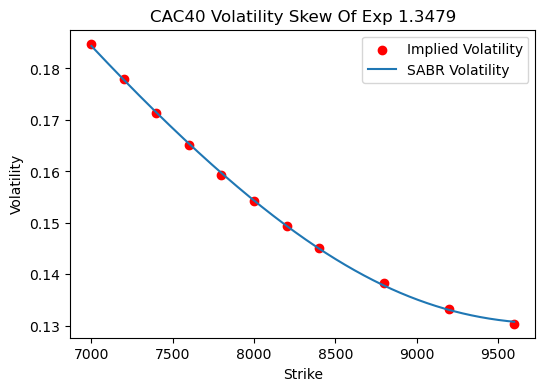

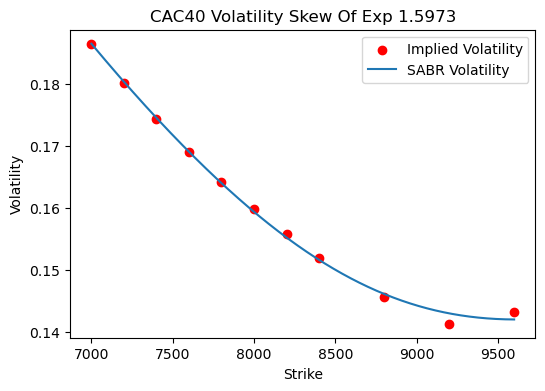

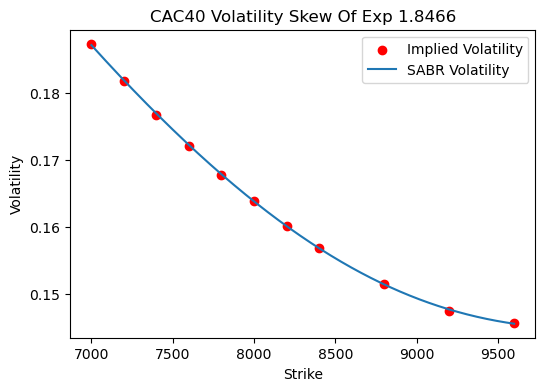

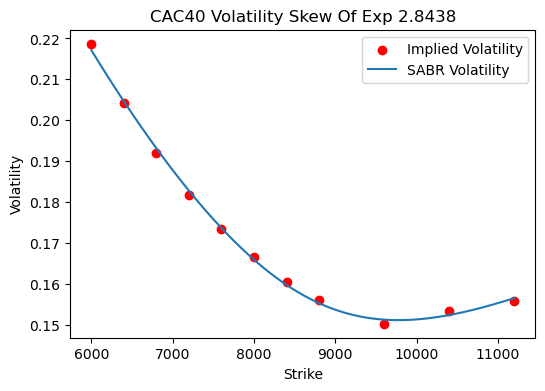

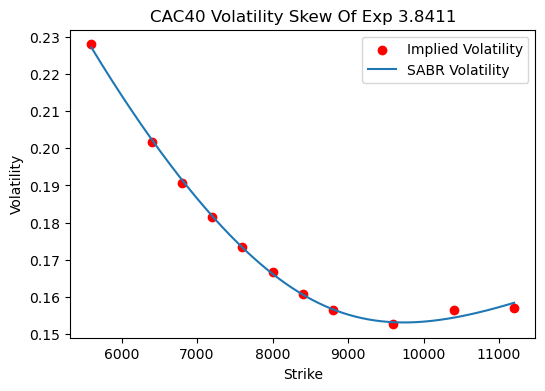

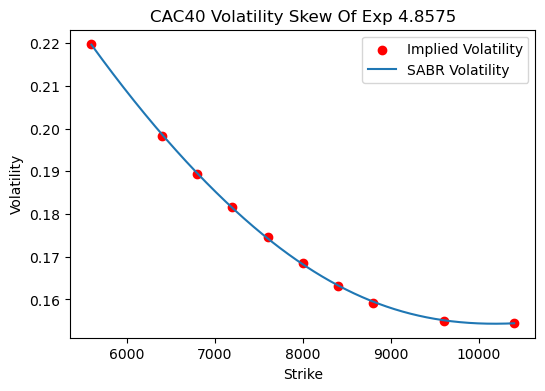

In [3]:
def collect_data(option_data):
    """
    Collects data and store it in dictionaries.
    """
    # Sanity checks
    if option_data is None or option_data.empty:
        raise ValueError("option_data cannot be None or empty.")
    required_cols = ['Expiry', 'Strike', 'Forward', 'Volatility']
    if not all(col in option_data.columns for col in required_cols):
        raise ValueError(f"option_data must contain columns: {required_cols}")
    if (option_data['Strike'] <= 0).any():
        raise ValueError("All strikes must be positive.")
    if (option_data['Forward'] <= 0).any():
        raise ValueError("All forwards must be positive.")
    if (option_data['Volatility'] < 0).any():
        raise ValueError("All volatilities must be non-negative.")
    if (option_data['Expiry'] <= 0).any():
        raise ValueError("All expiries must be positive.")
    # Data collection
    implied_forwards, strikes, implied_vols  = dict(), dict(), dict()
    expiries = sorted(map(float, np.unique(option_data["Expiry"])))
    for exp in expiries :
        df = option_data[option_data['Expiry'] == exp]
        # Forward values must be unique per expiry
        fwds = df["Forward"].to_numpy(dtype=float)
        ref = float(np.median(fwds))
        if not np.all(np.isclose(fwds, ref, atol=1e-12)):
            raise ValueError(
                f"Forward not near-unique for expiry={exp}: "
                f"min={fwds.min()}, max={fwds.max()}, median={ref}"
            )
        implied_forwards[round(exp, 12)] = ref
        # Store strikes and volatilities
        df = df.sort_values(by=['Strike'])
        strikes[round(exp, 12)], implied_vols[round(exp, 12)] = list(df['Strike']), list(df['Volatility']) 
    return {"Forwards" : implied_forwards, "Strikes" : strikes, "Volatilities" : implied_vols}    

# Collected Data
data = collect_data(option_data)
implied_forwards = data["Forwards"]
market_expiries = sorted(list(implied_forwards.keys()))
market_strikes = data["Strikes"]
market_vols = data["Volatilities"]

# SABR model
sabr_model = SABRModel()
beta = 0.8
sabr_model.params_calibration(market_expiries, implied_forwards, market_strikes, market_vols, beta=beta)

# SABR Volatility Skews
print()
plt.rcParams["figure.figsize"] = (6,4)
print(eq_underlying + " SABR Volatility Skews :")
for exp in market_expiries:
    plt.title(eq_underlying + " Volatility Skew Of Exp " + str(round(exp, 4)))
    plt.ylabel("Volatility")
    plt.xlabel("Strike")
    plt.scatter(market_strikes[exp], market_vols[exp], color="red", label="Implied Volatility")
    x_axis = np.linspace(market_strikes[exp][0], market_strikes[exp][-1], 1000)
    vol_func = sabr_model.get_sabr_vol(exp, x_axis, implied_forwards[exp], sabr_model.params[exp][0], sabr_model.params[exp][1], sabr_model.params[exp][2], sabr_model.params[exp][3])
    plt.plot(x_axis, vol_func, label="SABR Volatility")
    plt.legend(loc="upper right")
    plt.show()


Then, let's construct the implied SABR volatility surface:

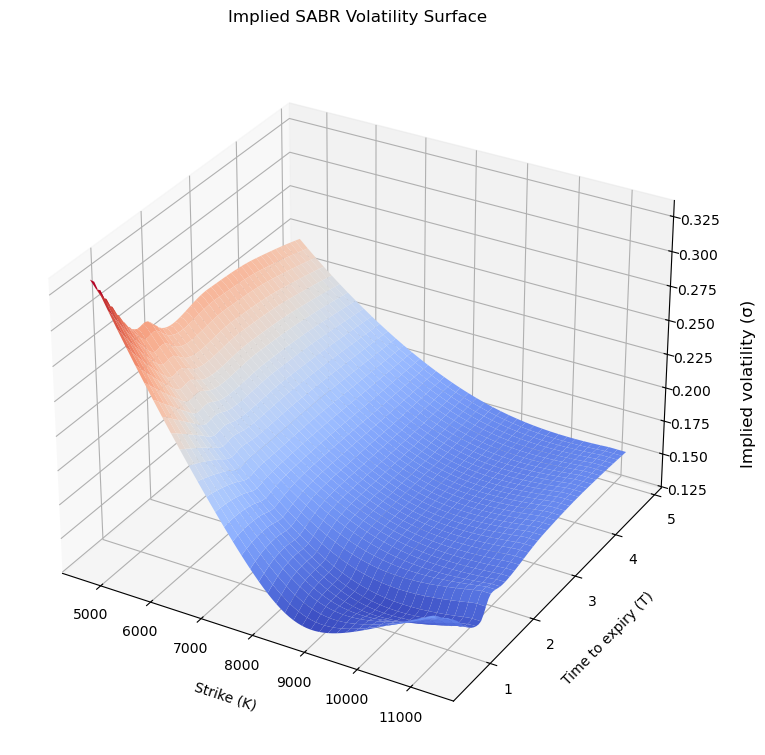

In [4]:
sabr_model.plot_sabr_surface()